In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
import cartopy.feature as cfeature
import glob
import cftime

I want to create the ensamble mean file. 

In [36]:
# List of file names
file_names = ['qtot_clm40_2a.nc4', 'qtot_dbh_2a.nc4', 'qtot_h08_2a.nc4', 'qtot_jul_2a.nc4', 'qtot_lpj_2a.nc4',
              'qtot_mat_2a.nc4', 'qtot_mpi_2a.nc4', 'qtot_orchidee_2a.nc4', 'qtot_pcr_2a.nc4', 'qtot_vic_2a.nc4',
              'qtot_ways_2a.nc4', 'qtot_watergap_2a.nc4', 'qtot_web-dhm_2a.nc4']

# Open each file and extract the qtot variable
qtot_list = []
for file in file_names:
    ds = xr.open_dataset(file)
    qtot_var = ds['qtot']*86400
    
    # Convert cftime object to datetime objects
    if isinstance(qtot_var.time.values[0], cftime.datetime):
        time_values = qtot_var.time.values.astype('datetime64[D]')
        qtot_var['time'] = (('time',), time_values)
    
    qtot_var.attrs['model'] = file.split('_')[1]  # Add model name as attribute
    qtot_list.append(qtot_var)

# Concatenate the qtot variables along a new 'model' dimension
qtot_concat = xr.concat(qtot_list, dim='model')

# Select the desired time range
qtot_concat = qtot_concat.sel(time=slice('1971-01-01', '2000-12-31'))

# Calculate the ensemble mean qtot 
qtot_ens_mean = qtot_concat.mean(dim='model')

#add the ensemble mean as if it was another model

qtot_ens_mean.attrs["model"] = "ensemble mean"
qtot_concat = xr.concat([qtot_concat, qtot_ens_mean], dim="model")
# Print the resulting DataArray
print(qtot_ens_mean)
lat = qtot_ens_mean.lat
lon = qtot_ens_mean.lon
time= qtot_ens_mean.time
year = qtot_ens_mean.time.dt.year

<xarray.DataArray 'qtot' (time: 10958, lat: 12, lon: 30)>
array([[[ 0.23491463,  0.42720899,  0.57766779, ...,  0.38114407,
          0.49374694,  0.44276891],
        [ 0.27957149,  0.29964645,  0.40387109, ...,  0.2041577 ,
          0.22422723,  0.18481779],
        [ 0.27967057,  0.29930362,  0.35730973, ...,  0.1452865 ,
          0.1470571 ,  0.13600537],
        ...,
        [ 0.66209123,  0.37393713,  0.25966922, ...,  0.87541489,
          1.99902695,  1.53919632],
        [ 0.41083069,  0.2875578 ,  0.4030958 , ...,  3.49958651,
          1.76071312,  3.18827635],
        [ 0.55039461,  0.16651575,  0.17554625, ..., 24.40688979,
         15.07316853, 12.46551737]],

       [[ 0.23452149,  0.42342883,  0.56763627, ...,  0.36738818,
          0.76080934,  0.74233051],
        [ 0.27630901,  0.29732081,  0.39186267, ...,  0.18789923,
          0.20840596,  0.20203738],
        [ 0.27751893,  0.29686954,  0.33413402, ...,  0.13048724,
          0.12501257,  0.11775409],
...
     

With the ensamble mean i can proceed to recreate the signatures from the paper of prof Viglione.

Lets start with the pixel of Turin. 

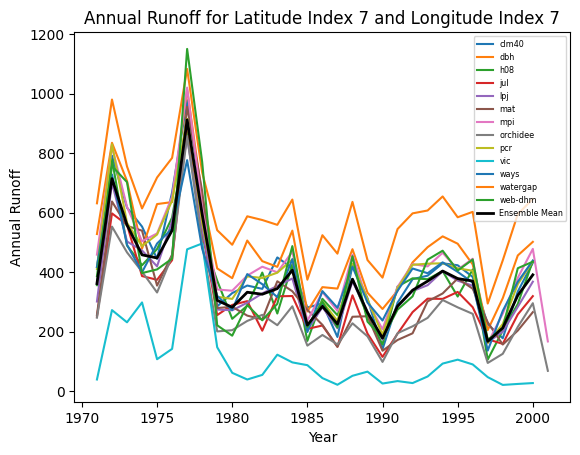

In [3]:

# Select the latitude and longitude index
lat_index = 7
lon_index = 7

# Calculate the annual runoff sum for each year and each model
qtot_annual_sum = []
for qtot_var in qtot_list:
    annual_sum = qtot_var.resample(time='A').sum(dim='time', keep_attrs=True)
    qtot_annual_sum.append(annual_sum)


    
qtot_ensemblemean_annual = qtot_ens_mean.groupby('time.year').sum(dim='time')

# Loop through the qtot_annual_sum list and plot the selected index
for i, qtot_annual in enumerate(qtot_annual_sum):
    model_name = file_names[i].split('_')[1]
    plt.plot(qtot_annual['time.year'], qtot_annual[:, lat_index, lon_index], label=model_name)

plt.plot(qtot_ensemblemean_annual['year'], qtot_ensemblemean_annual[:, lat_index, lon_index], label='Ensemble Mean', linewidth=2, color='black')

# Set the plot title, x-axis label, and y-axis label
plt.title('Annual Runoff for Latitude Index {} and Longitude Index {}'.format(lat_index, lon_index))
plt.xlabel('Year')
plt.ylabel('Annual Runoff')

# Add a legend
plt.legend(fontsize='xx-small')

# Show the plot
plt.show()

Same with the monhtly regime

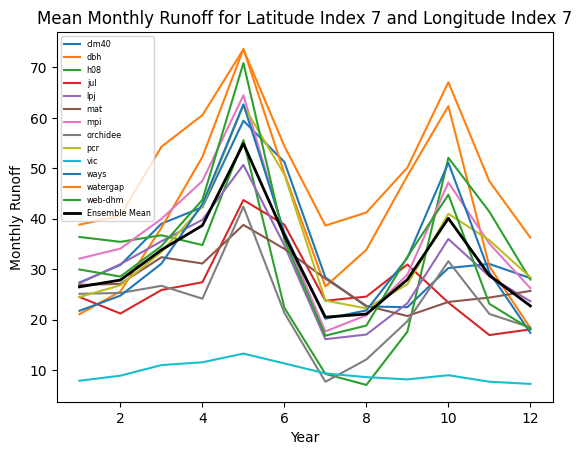

In [4]:
qtot_monthly_mean = []
for qtot_var in qtot_list:
    monthly_sum = qtot_var.resample(time='1M').sum(dim='time', keep_attrs=True)
    qtot_monthly_mean.append(monthly_sum.groupby('time.month').mean())
    
qtot_ensemblemean_monthlysum = qtot_ens_mean.resample(time = '1M').sum(dim='time')
qtot_ensemblemean_monthlymean = qtot_ensemblemean_monthlysum.groupby('time.month').mean()


# Loop through the qtot_monhtly_mean list and plot the selected index
for i, qtot_monthly in enumerate(qtot_monthly_mean):
    model_name = file_names[i].split('_')[1]
    plt.plot(qtot_monthly['month'], qtot_monthly[:, lat_index, lon_index], label=model_name)

plt.plot(qtot_ensemblemean_monthlymean['month'], qtot_ensemblemean_monthlymean[:, lat_index, lon_index], label='Ensemble Mean', linewidth=2, color='black')

# Set the plot title, x-axis label, and y-axis label
plt.title('Mean Monthly Runoff for Latitude Index {} and Longitude Index {}'.format(lat_index, lon_index))
plt.xlabel('Year')
plt.ylabel('Monthly Runoff')

# Add a legend
plt.legend(fontsize='xx-small')

# Show the plot
plt.show()

Now work with only the ensamble mean to obtain the maps

First signature; Mean annual Specific Runoff



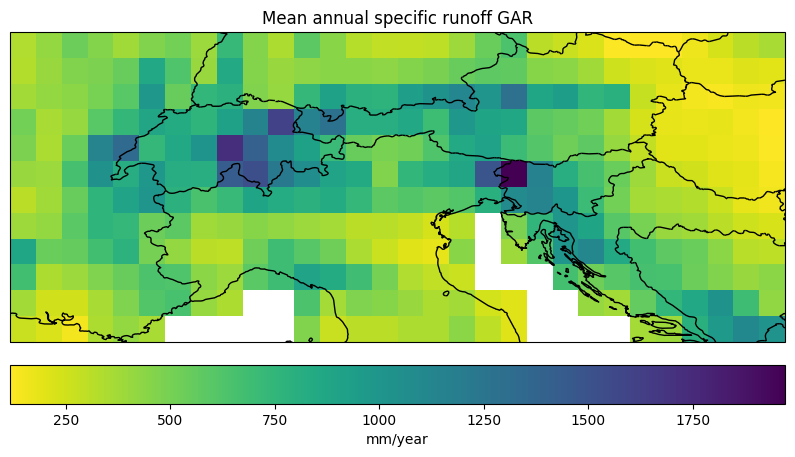

In [5]:
Q_mean = qtot_ens_mean.mean(dim='time')*365

masked_data = np.ma.masked_invalid(Q_mean)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cmap = plt.get_cmap('viridis')
im = ax.pcolormesh(Q_mean.lon, Q_mean.lat, masked_data, cmap=cmap, transform=ccrs.PlateCarree())
inverted_cmap = cmap.reversed()
im = ax.pcolormesh(Q_mean.lon, Q_mean.lat, masked_data, cmap=inverted_cmap, transform=ccrs.PlateCarree())
ax.set_title('Mean annual specific runoff GAR')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
cbar.ax.set_xlabel('mm/year')
cbar.ax.xaxis.set_label_position('bottom')
plt.show()


Step 2: pardè Coefficient= mean monthly runoff(i= 1:12) / mean annual runoff Parde range = Max(Pardè) - Min(Pardè)

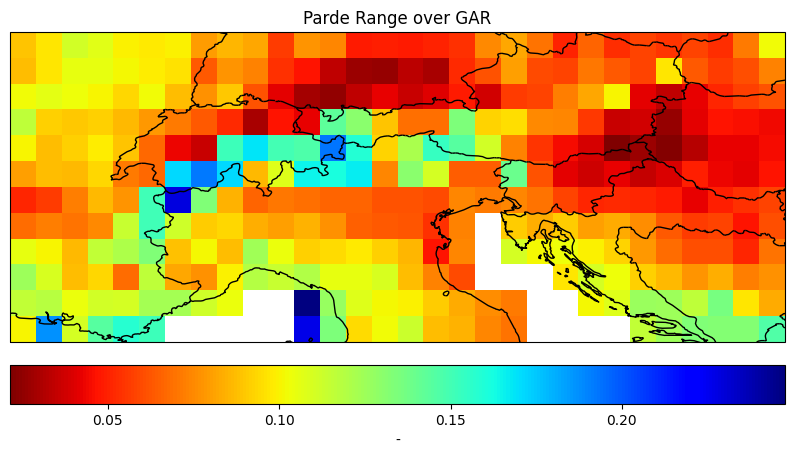

In [6]:
qmonthly= qtot_ens_mean.groupby('time.month').sum(dim='time')
qyearly= qtot_ens_mean.sum(dim='time')


Parde= qmonthly/qyearly
Parde_max= Parde.max(dim='month')
Parde_min= Parde.min(dim='month')

Range= Parde_max- Parde_min

masked_Range = np.ma.masked_invalid(Range)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cmap = plt.get_cmap('jet')
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_Range, cmap=cmap, transform=ccrs.PlateCarree())
inverted_cmap = cmap.reversed()
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_Range, cmap=inverted_cmap, transform=ccrs.PlateCarree())
ax.set_title('Parde Range over GAR')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
cbar.ax.set_xlabel('-')
cbar.ax.xaxis.set_label_position('bottom')
plt.show()

Now for the slope of the central part of the flow duration curve.

Slope_FDC = Q30-Q70/ Q_daily_mean



Normalized Low flows 

Q_95/qmean

Integral time scale

In [7]:
mean_daily = qtot_ens_mean.mean(dim='time')
variance = np.empty((1,12,30))
for i in range(0,12):
    for j in range(0,30):
        dummy= np.var(qtot_ens_mean[:,i,j])
        variance[:,i,j]= dummy 
        

q_normalized= qtot_ens_mean-mean_daily



acorr = np.empty((len(q_normalized),12,30))

for i in range(0,12):
    for j in range(0,30):
        dummy= np.correlate(q_normalized[:,i,j], q_normalized[:,i,j], 'full')[len(q_normalized)-1:] 
        acorr[:,i,j]= dummy/ variance[:,i,j]/len(q_normalized)
        



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xarray/core/nputils.py:157: 

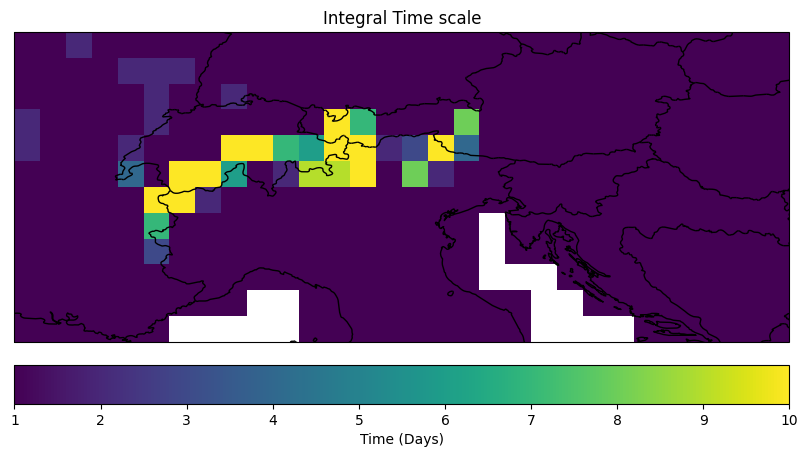

In [8]:
autocorr = np.array(acorr)
maxi = np.empty((1,12,30))

for i in range(0,12):
    for j in range(0,30):
            dummyy = np.where(autocorr[:,i,j] > 0.386)[0]
            if np.isnan(autocorr[:,i,j]).any() == 1:
                maxi[:,i,j]= np.nan
            elif np.isnan(autocorr[:,i,j]).any() == 0:
                maxi[0,i,j]= dummyy[-1]


masked_maxi = np.ma.masked_invalid(maxi)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cmap = plt.get_cmap('viridis')
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_maxi[0,:,:], cmap=cmap,vmin=1, vmax=10,  transform=ccrs.PlateCarree())
ax.set_title('Integral Time scale')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
cbar.ax.set_xlabel('Time (Days)')
cbar.ax.xaxis.set_label_position('bottom')
plt.show()

Lets try another way to calculate the fdc: i want to create a fdc for each year, then i want to create the average year fdc.  Lets do it first in one pixel then expand over the whole region.

In [9]:
annual_fdc = np.empty((365,12,30,30))
yy = np.arange(1971,2001)
for i in range(0,29):
    for j in range(0,12):
        for k in range(0,30):
            dummy = np.sort(qtot_ens_mean[year== yy[i],j,k])[::-1]
            annual_fdc[:,j,k,i]= dummy[0:365]

annual_fdc.shape
    

(365, 12, 30, 30)

In [10]:
#plt.plot(np.arange(0,365), annual_fdc[:, 11, 10,1], label='Ensemble Mean', linewidth=2, color='black')
#plt.yscale("log")
#scelto apposta un pixel vuoto

Seems ok , lets do the mean fdc:

In [11]:
mean_fdc = np.mean(annual_fdc, axis= 3)
mean_fdc.shape

(365, 12, 30)

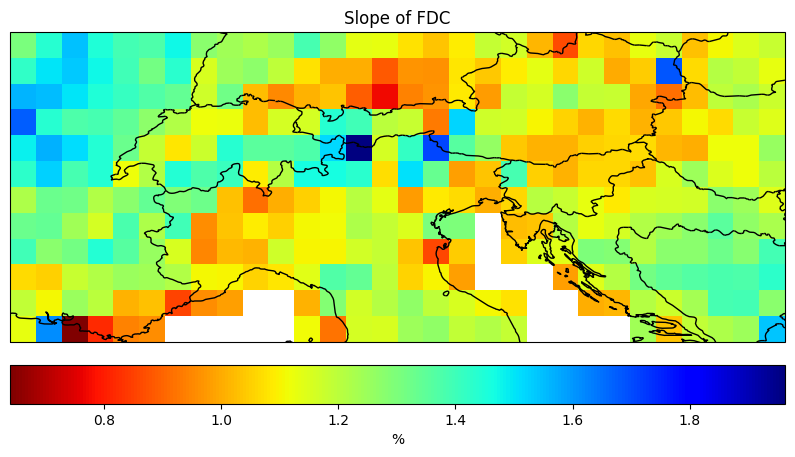

In [12]:
mean_daily = qtot_ens_mean.mean(dim='time')
exceeded_30= mean_fdc[111,:,:]
exceeded_70= mean_fdc[256,:,:]
mfdc= 100* (exceeded_30-exceeded_70)/(40*mean_daily)

masked_mfdc = np.ma.masked_invalid(mfdc)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cmap = plt.get_cmap('jet')
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_mfdc, cmap=cmap, transform=ccrs.PlateCarree())
inverted_cmap = cmap.reversed()
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_mfdc, cmap=inverted_cmap, transform=ccrs.PlateCarree())
ax.set_title('Slope of FDC')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
cbar.ax.set_xlabel('%')
cbar.ax.xaxis.set_label_position('bottom')
plt.show()

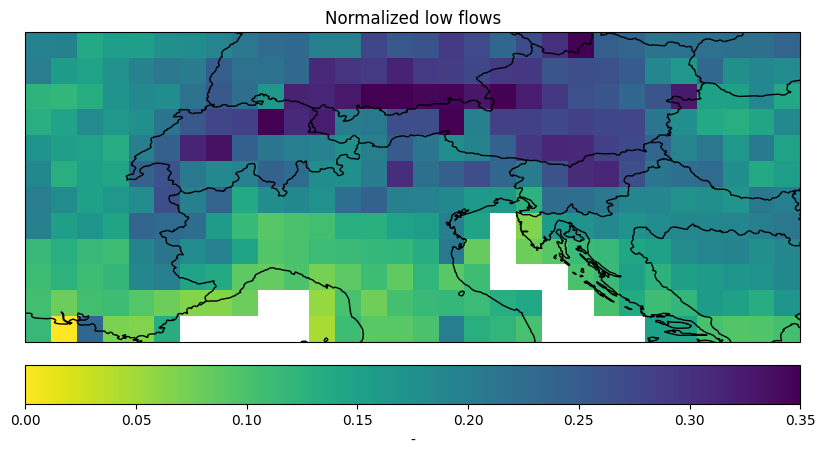

In [13]:
exceeded_95 =  mean_fdc[347,:,:]

Qlow = exceeded_95/mean_daily

masked_Qlow = np.ma.masked_invalid(Qlow)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cmap = plt.get_cmap('viridis')
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_Qlow, cmap=cmap, transform=ccrs.PlateCarree())
inverted_cmap = cmap.reversed()
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_Qlow, cmap=inverted_cmap, vmin=0, vmax=0.35, transform=ccrs.PlateCarree())
ax.set_title('Normalized low flows')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
cbar.ax.set_xlabel('-')
cbar.ax.xaxis.set_label_position('bottom')
plt.show()

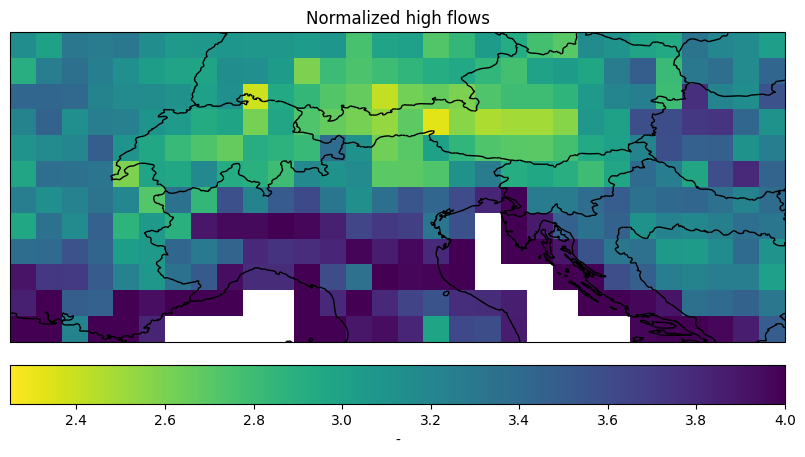

In [14]:
exceeded_5 =  mean_fdc[18,:,:]

Qlow = exceeded_5/mean_daily

masked_Qlow = np.ma.masked_invalid(Qlow)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cmap = plt.get_cmap('viridis')
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_Qlow, cmap=cmap, transform=ccrs.PlateCarree())
inverted_cmap = cmap.reversed()
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_Qlow, cmap=inverted_cmap, vmin=2.25, vmax=4, transform=ccrs.PlateCarree())
ax.set_title('Normalized high flows')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
cbar.ax.set_xlabel('-')
cbar.ax.xaxis.set_label_position('bottom')
plt.show()

Ok, all the signatures for the past in the ensamble mean are derived. Now the analysis could go on for the variability. For instance for each signature i could take the model who has the largest variation of that signature in that pixel i.e. the largest difference compared to the ensamble mean, then plot for all the pixel and for each signature the relative variability for the whole region. 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xarray/core/computation.py:760: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)


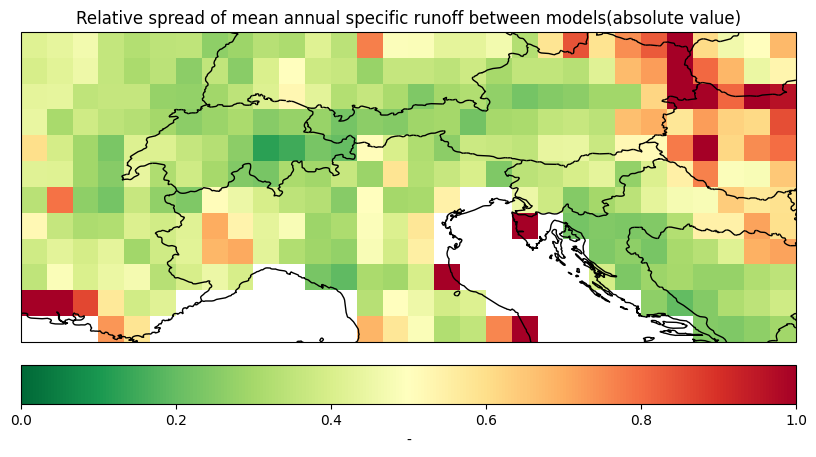

In [15]:
annualmeanrunoff_allmodels = []
for qtot_var in qtot_list:
    annualmean = qtot_var.mean(dim='time', keep_attrs=True)*365
    annualmeanrunoff_allmodels.append(annualmean)
    
    
max_variability = np.empty((1,12,30))
absolute_variability = np.empty((len(annualmeanrunoff_allmodels),12,30))
max_absolute_variability = np.empty((1,12,30))
for i in range(len(annualmeanrunoff_allmodels)):
            model_mean = annualmeanrunoff_allmodels[i]
            absolute_variability[i,:,:] = np.abs(model_mean - Q_mean)
            max_variability[:,:,:] = (absolute_variability[:,:,:].max(axis=0)) / Q_mean

            
masked_max_variability = np.ma.masked_invalid(max_variability)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cmap = plt.get_cmap('RdYlGn')
im = ax.pcolormesh(Range.lon, Q_mean.lat,masked_max_variability[0,:,:], cmap=cmap, transform=ccrs.PlateCarree())
inverted_cmap = cmap.reversed()
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_max_variability[0,:,:], cmap=inverted_cmap, vmin=0, vmax=1, transform=ccrs.PlateCarree())
ax.set_title('Relative spread of mean annual specific runoff between models(absolute value)')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
cbar.ax.set_xlabel('-')
cbar.ax.xaxis.set_label_position('bottom')
plt.show()


In [16]:
absolute_variability[:,11,0]

array([         nan, 173.54836166, 146.70276446, 183.22771199,
        52.45164718, 350.44716168, 178.52119426,          nan,
        36.15181235, 190.75012788,          nan,  35.53645727,
       228.6195602 ])

seems like some models have different coastlines , or maybe different reference systems? In any case i like more this map than the previous that had too many pixels on the sea.

Importo i dati del GRDC:
Per prima cosa trimmo rispetto ai catchment troppo grandi rispetto alle dimensioni del pixel, poi vedo come sono distribuiti gli altri. 

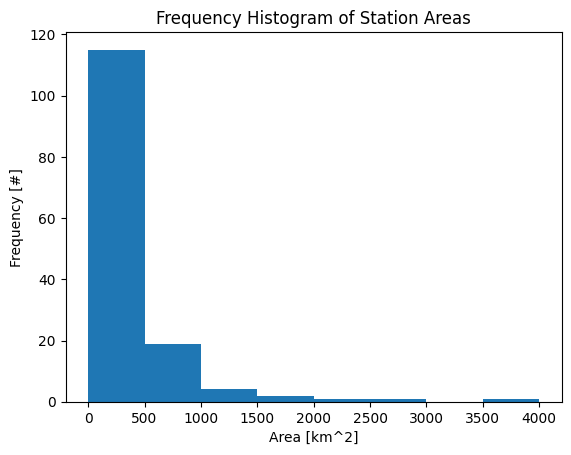

In [17]:
# Open the original dataset
dis_grdc = xr.open_dataset('GRDC-Daily.nc')
# Trim the dataset based on area
dis_grdc_trimmed = dis_grdc.where(dis_grdc.area <= 10000, drop=True)
dis_grdc_trimmed=dis_grdc_trimmed.where(dis_grdc_trimmed.area >= 0, drop=True)
# Calculate the frequency histogram of station areas
bin_size = 500
bins = range(0, 4001, bin_size)
hist, bin_edges = np.histogram(dis_grdc_trimmed.area.values, bins=bins)

# Plot the frequency histogram
plt.bar(bin_edges[:-1], hist, width=bin_size, align='edge')
plt.xlabel('Area [km^2]')
plt.ylabel('Frequency [#]')
plt.title('Frequency Histogram of Station Areas')
plt.show()


In [18]:
# Convert runoff from cubic meter per second to mm/day
runoff_mm_day = ((dis_grdc_trimmed['runoff_mean'] / dis_grdc['area']) / 1000) * 86400

# Create a new dataset with restructured coordinates
new_dataset = xr.Dataset(
    {
        'runoff': runoff_mm_day,
    },
    coords={
        'time': dis_grdc['time'],
        'latitude': dis_grdc['geo_y'],
        'longitude': dis_grdc['geo_x'],
    }
)

new_dataset =new_dataset.sel(time=slice('1971-01-01', '2000-12-31'))
new_dataset = new_dataset.where(new_dataset['id'] != 6139391, drop=True)
# Print the new dataset
print(new_dataset)

qtot_obs=new_dataset['runoff']

<xarray.Dataset>
Dimensions:    (time: 10958, id: 143)
Coordinates:
  * time       (time) datetime64[ns] 1971-01-01 1971-01-02 ... 2000-12-31
  * id         (id) int32 6128110 6128701 6128710 ... 6948360 6948520 6948530
    latitude   (id) float32 43.94 43.91 44.25 43.88 ... 46.49 46.37 46.2 46.22
    longitude  (id) float32 7.516 7.195 6.934 6.539 ... 9.898 8.543 9.169 8.015
Data variables:
    runoff     (time, id) float64 1.424 0.9726 1.097 ... 1.724 1.501 0.624


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


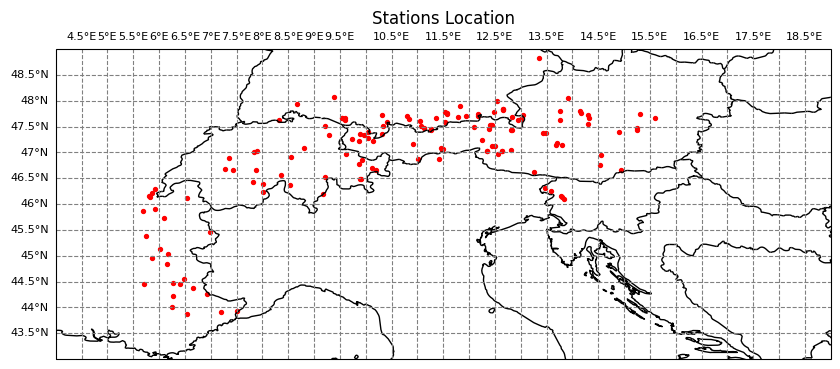

In [19]:


# Get the latitude and longitude coordinates of the stations
latitude = dis_grdc_trimmed['geo_y']
longitude = dis_grdc_trimmed['geo_x']

# Create a map projection
projection = ccrs.PlateCarree()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': projection})

# Plot the station locations
ax.scatter(longitude, latitude, color='red', marker='o',s=8, transform=projection)

# Add map features
ax.coastlines()
ax.set_extent([4, 19, 43, 49], crs=projection)
gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray',
             xlocs=[4.50, 5.0, 5.5, 6.0, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5,
                    11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5, 16,
                    16.5, 17, 17.5, 18, 18.5, 19],
             ylocs=[43.0, 43.5, 44, 44.5, 45, 45.5, 46.0, 46.5, 47, 47.5, 48, 48.5],
             x_inline=False, y_inline=False)

gl.xlabels_bottom = False
gl.xlabel_style = {'rotation': 0, 'size': 8, 'color': 'black'}

# Move the y-axis labels to the right
gl.ylabels_right = False
gl.ylabel_style = {'rotation': 0, 'size': 8, 'color': 'black'}
# Set plot title and labels
ax.set_title('Stations Location')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.add_feature(cfeature.BORDERS)
# Show the plot
plt.show()

For each station i now want to obtain the flow duration curves of each year. And each year i need to extrapolate the Q95 and Q5. Probably to do that i need to, first fill the gaps in the observed data for each station. 

Create a mean year for each station. 

In [20]:
qtot_meandayofyear = qtot_obs.groupby('time.dayofyear').mean()


Fill the gaps

In [21]:
# Iterate over each station
for station_idx in range(len(qtot_obs.id)):
    # Iterate over each day of the recording
    for day_of_year in range(366):
        # Check if the value is NaN
        nan_indices = np.isnan(qtot_obs.sel(id=qtot_obs.id[station_idx]).sel(time=qtot_obs.time.dt.dayofyear == day_of_year))
        if np.any(nan_indices):
            # Replace NaN values with mean values from qtot_meandayofyear
            mean_value = qtot_meandayofyear[day_of_year,station_idx]
            qtot_obs.loc[dict(id=qtot_obs.id[station_idx], time=qtot_obs.time.dt.dayofyear == day_of_year)] = \
                np.where(nan_indices, mean_value, qtot_obs.sel(id=qtot_obs.id[station_idx]).sel(time=qtot_obs.time.dt.dayofyear == day_of_year))


Now combine the station with the matching pixel

In [37]:

# Create an empty array with the desired dimensions and coordinates
combined_data = xr.DataArray(data=None, dims=['realizations', 'time', 'id'], coords={'realizations': np.arange(15), 'time': qtot_obs.time, 'id': qtot_obs.id})

# Assign the runoff timeseries from qtot_obs to the new array
combined_data[0, :, :] = qtot_obs

# Loop over the stations (ids)
for i, station_id in enumerate(qtot_obs.id.values):
    # Find the nearest pixel in qtot_concat based on latitude and longitude
    nearest_pixel = qtot_concat.sel(lat=qtot_obs.sel(id=station_id).latitude, lon=qtot_obs.sel(id=station_id).longitude, method='nearest')
    
    # Get the model timeseries for the nearest pixel
    model_timeseries = nearest_pixel.values
    
    # Assign the model timeseries to the combined array
    combined_data[1:, :, i] = model_timeseries
    
    
# Create the model names array
model_names = ['observations','clm40', 'dbh', 'ho8', 'jul', 'lpj', 'mat', 'mpi', 'orchidee', 'pcr', 'vic', 'ways', 'watergap', 'web-dhm', 'ensemble mean']

# Set the 'model' attribute for the model timeseries
combined_data = combined_data.assign_attrs(model=model_names)
combined_data = combined_data.astype(float)
combined_data = combined_data.where(combined_data['id'] != 6128110, drop=True)
combined_data = combined_data.where(combined_data['id'] != 6128701, drop=True)
# Find all time steps corresponding to the 29th of February
leap_year_dates = combined_data.time[combined_data.time.dt.is_leap_year & (combined_data.time.dt.month == 2) & (combined_data.time.dt.day == 29)]

# Remove the time steps corresponding to the 29th of February from the array
combined_data = combined_data.where(~combined_data.time.isin(leap_year_dates), drop=True)

combined_data[0] = combined_data[0].fillna(0)
# Print the combined array
print(combined_data)

<xarray.DataArray (realizations: 15, time: 10950, id: 141)>
array([[[1.09681436e+00, 5.88311456e-01, 1.48607984e+00, ...,
         4.31999989e-01, 2.14392044e-01, 6.54545530e-01],
        [1.06577245e+00, 5.79077833e-01, 1.48607984e+00, ...,
         4.31999989e-01, 2.14392044e-01, 6.98181862e-01],
        [1.06577245e+00, 5.32909918e-01, 1.54367986e+00, ...,
         4.31999989e-01, 2.14392044e-01, 7.41818233e-01],
        ...,
        [9.29783001e-01, 2.18967943e+00, 1.91462403e+00, ...,
         1.87920016e+00, 1.52218358e+00, 6.06545435e-01],
        [1.02541796e+00, 2.08415263e+00, 1.61279992e+00, ...,
         1.79279998e+00, 1.50074435e+00, 6.37090950e-01],
        [0.00000000e+00, 1.96543502e+00, 1.40313609e+00, ...,
         1.72440003e+00, 1.50074435e+00, 6.24000054e-01]],

       [[2.16905476e+00, 5.92434802e+00, 2.06001338e+00, ...,
         2.66446201e+00, 2.74810733e+00, 2.21114616e+00],
        [2.13428563e+00, 9.88385745e-01, 2.03608723e+00, ...,
         2.58924962e+00

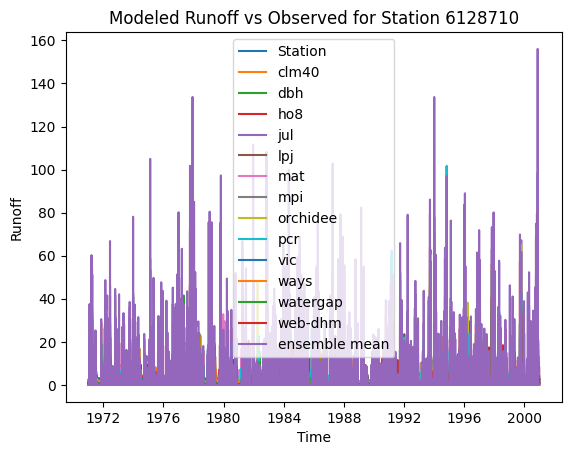

In [38]:

# Get the timeseries for the station with id index 0
station_timeseries = combined_data[:, :, 0]

# Get the model names from the 'model' attribute
model_names = combined_data.attrs['model']

# Update the plot code
plt.plot(station_timeseries.time, station_timeseries[0, :], label='Station')
for i, model in enumerate(model_names[1:]):  # Exclude the first entry (station)
    plt.plot(station_timeseries.time, station_timeseries[i , :], label=model)



# Add legend with model names
plt.legend()

# Set x-axis and y-axis labels and title
plt.xlabel('Time')
plt.ylabel('Runoff')
plt.title(f"Modeled Runoff vs Observed for Station {combined_data.id.values[0]}")

# Show the plot
plt.show()

In [39]:
realizations = combined_data.realizations
ids = combined_data.id
years = np.unique(combined_data.time.dt.year)  # Get unique years
years_datetime = pd.to_datetime(years, format="%Y") 

annual_q95 = np.zeros((len(realizations), len(years), len(ids)))
annual_5 = np.zeros((len(realizations), len(years), len(ids)))

for i, realization in enumerate(realizations):
    for j, year in enumerate(years):
        for k, id in enumerate(ids):
            runoff_yearly = combined_data[realization, combined_data.time.dt.year == year, ids==id ]
            sorted_yearly = np.sort(runoff_yearly.values)[::-1]  # Sort yearly values in descending order
            annual_q95[i, j, k] = sorted_yearly[346]  # Extract 347th element
            annual_5[i, j, k] = sorted_yearly[17]  # Extract 18th element
            

            
annual_q95 = xr.DataArray(
    annual_q95,
    coords=[realizations, years_datetime, ids],
    dims=["realization", "time", "id"],
    name="annual_q95"
)

annual_5 = xr.DataArray(
    annual_5,
    coords=[realizations, years_datetime, ids],
    dims=["realization", "time", "id"],
    name="annual_5"
)

# Assign the 'model' attribute to annual_5
annual_5 = annual_5.assign_attrs(model=model_names)

# Assign the 'model' attribute to annual_q95
annual_q95 = annual_q95.assign_attrs(model=model_names)

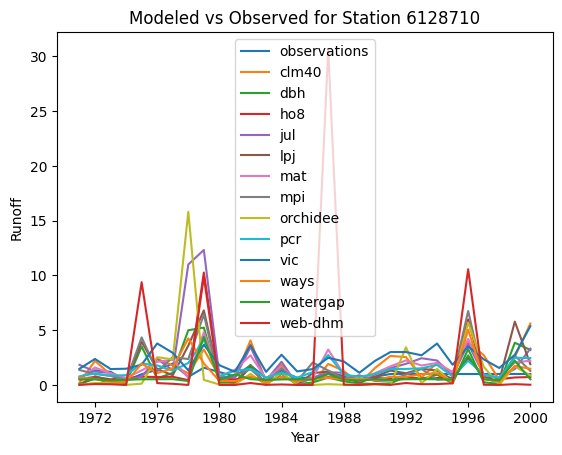

In [34]:
# Select the data for station with id index 0
data_station = annual_5.isel(id=0)

# Plot the realizations
for i, realization in enumerate(data_station.realization):
    label = data_station.attrs['model'][i]  # Get the label from the 'model' attribute
    plt.plot(data_station.time, data_station[realization,:], label=label)

# Add labels, title, and legend
plt.xlabel('Year')
plt.ylabel('Runoff')
plt.title(f'Modeled vs Observed for Station {data_station.id.item()}')
plt.legend()

# Show the plot
plt.show()

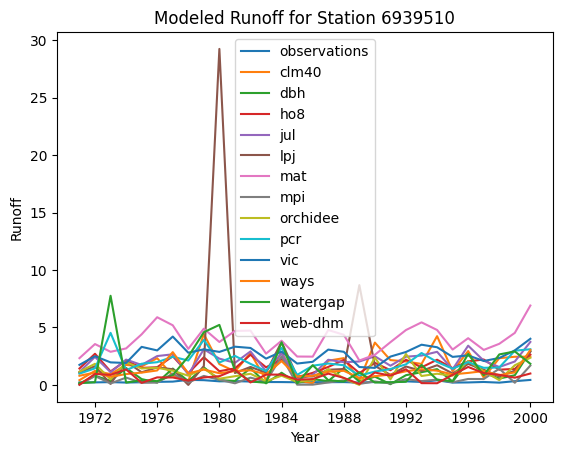

In [40]:
# Select the data for station with id index 0
data_station_2 = annual_5.isel(id=132)

# Plot the realizations
for i, realization in enumerate(data_station.realization):
    label = data_station.attrs['model'][i]  # Get the label from the 'model' attribute
    plt.plot(data_station.time, data_station_2[realization,:], label=label)

# Add labels, title, and legend
plt.xlabel('Year')
plt.ylabel('Runoff')
plt.title(f'Modeled Runoff for Station {data_station_2.id.item()}')
plt.legend()

# Show the plot
plt.show()

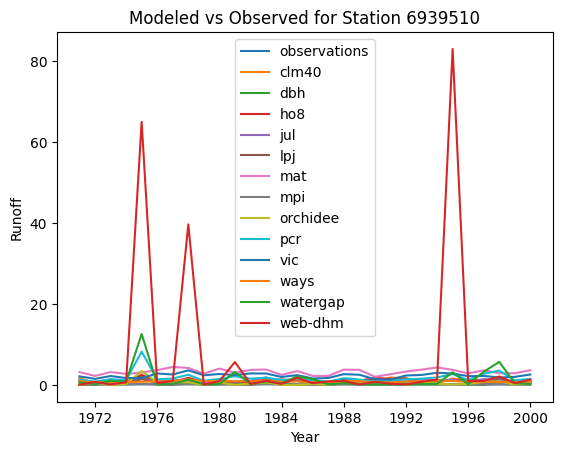

In [41]:
# Select the data for station with id index 0
data_station_3 = annual_q95.isel(id=132)

# Plot the realizations
for i, realization in enumerate(data_station.realization):
    label = data_station.attrs['model'][i]  # Get the label from the 'model' attribute
    plt.plot(data_station.time, data_station_3[realization,:], label=label)

# Add labels, title, and legend
plt.xlabel('Year')
plt.ylabel('Runoff')
plt.title(f'Modeled vs Observed for Station {data_station_3.id.item()}')
plt.legend()

# Show the plot
plt.show()

Commento. i Gap sono stati fillati la procedura sembra andata bene, sti q5 e q95 invece sono strani e sbagliati. Impossibile che il q sorpassato 95% del tempo ( ovvero un q bassissim, schizzi a quei livelli. Bisogna andare a vedere per quell'anno e per quel modello se cè qualcosa che è andato storto. tralaltro rivedere un attimo combined_data perchè ho levato l'ensemble mean in qualche modo.